# Set up the environment


In [1]:
! pip install numpy matplotlib moviepy
! pip install gymnasium pyvirtualdisplay
! pip install "gymnasium[other]"

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import logger as gymlogger
from gymnasium.wrappers import RecordVideo	
from IPython.display import HTML
import pickle
import os
from tqdm import trange

import os
import imageio
import datetime
from PIL import Image
from IPython.display import Video

random.seed(42)
gymlogger.min_level = 10 

### Create the environment

In [3]:
env = gym.make('CartPole-v1')

### Discretization parameters

In [4]:
PositionRange=4.8
AngleRange=0.418

bins={
    "position": 30,
    "velocity": 30,
    "pole_angle": 40,
    "pole_velocity": 40,
}


In [11]:
def discretize(value, min_val, max_val, num_bins):
    if value > max_val:
        return num_bins - 1
    elif value < min_val:
        return 0
    else:
        return round((value - min_val) / (max_val - min_val) * (num_bins - 1))

In [12]:
NUM_STATES = np.prod(list(bins.values()))

In [13]:
def get_hashed_state(observation):
    """Convert observation into a single integer state representation."""
    position, velocity, pole_angle, pole_velocity = observation
    state_tuple = (
        discretize(position, -PositionRange, PositionRange, bins["position"]),
        discretize(velocity, -3.0, 3.0, bins["velocity"]),
        discretize(pole_angle, -AngleRange, AngleRange, bins["pole_angle"]),
        discretize(pole_velocity, -3.0, 3.0, bins["pole_velocity"])
    )
    
    hashed_state = 0
    multiplier = 1
    for key, value in zip(bins.keys(), state_tuple):
        hashed_state += value * multiplier
        multiplier *= bins[key]
    
    return hashed_state

Define Q-learning agent

In [34]:
class QLearningAgent:
    def __init__(self, alpha=0.1, gamma=0.99, epsilon=1.0):
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = np.zeros((NUM_STATES, 2))
        self.episode_rewards = []

    def get_action(self, state):
        """Epsilon-greedy policy"""
        if random.random() < self.epsilon:
            return random.randint(0, 1)  # Explore
        else:
            return np.argmax(self.q_table[state])  # Exploit

    def train(self, env, num_episodes=8500, smooth_window=100):
        """Train the Q-learning agent"""
        self.episode_rewards = []

        for episode in trange(num_episodes, desc="Training", unit="episode"):
            observation, _ = env.reset()
            state = get_hashed_state(observation)
            done = False
            total_reward = 0

            while not done:
                action = self.get_action(state)
                next_observation, reward, done, _, _ = env.step(action)
                next_state = get_hashed_state(next_observation)

                # Q-learning update
                self.q_table[state, action] += self.alpha * (
                    reward + self.gamma * np.max(self.q_table[next_state]) - self.q_table[state, action]
                )

                total_reward += reward
                state = next_state

            self.episode_rewards.append(total_reward)

            # Decay epsilon gradually after every 10 episodes
            if episode % 10 == 0:
                self.epsilon = max(self.epsilon * 0.995, 0.05)

        self.plot_rewards(smooth_window)

    def plot_rewards(self, smooth_window=100):
        """Plot moving average of rewards."""
        rewards = np.convolve(self.episode_rewards, np.ones(smooth_window) / smooth_window, mode="valid")
        plt.plot(rewards)
        plt.xlabel("Episode")
        plt.ylabel("Reward")
        plt.title("Q-learning Training Performance")
        plt.show()
    
    def save(self, path="models", model_name="QL_Model"):
        """Save the Q-table to a file."""
        os.makedirs(path, exist_ok=True)
        filename = f"{model_name}.pkl"
        full_path = os.path.join(path, filename)
        with open(full_path, "wb") as f:
            pickle.dump(self.q_table, f)
        print(f"Model saved to {full_path}")

    def load(self, file_path):
        """Load the Q-table from a file."""
        with open(file_path, "rb") as f:
            self.q_table = pickle.load(f)
        print(f"Model loaded from {file_path}")


Training: 100%|██████████| 30000/30000 [12:50<00:00, 38.94episode/s]  


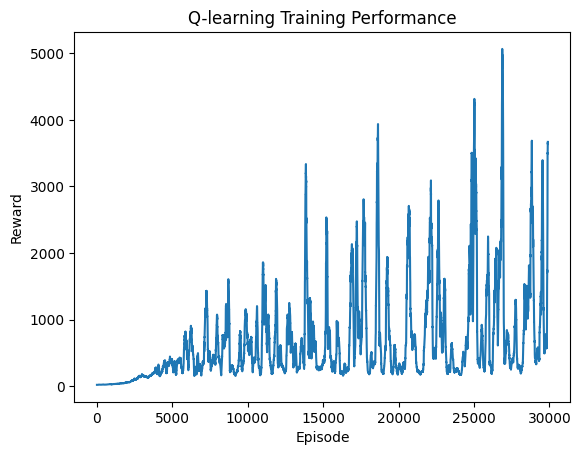

In [35]:
agent = QLearningAgent()
agent.train(env, num_episodes=30000)

# Task 1: Test the agent on a random state

In [36]:
observation, _ = env.reset()
state = get_hashed_state(observation)
action = agent.get_action(state)
print("Observation:", observation)
print("Chosen action:", action)

Observation: [-0.02478753 -0.00116568  0.02546129 -0.0442797 ]
Chosen action: 0


In [37]:
agent.save("models", "QL_windows")

Model saved to models\QL_windows.pkl


In [38]:
import gymnasium as gym
import numpy as np
import pickle
import os

def play_episode(agent, env, render=False):
    """Simulate one episode using the trained agent (always exploiting)."""
    observation, _ = env.reset()
    
    # Ensure valid observation
    if observation is None:
        print("Warning: Received None as initial observation, retrying reset.")
        observation, _ = env.reset()
    
    state = get_hashed_state(observation)
    done = False
    total_reward = 0

    while not done and total_reward < 500:
        action = np.argmax(agent.q_table[state])  # Always exploit
        next_observation, reward, done, _, _ = env.step(action)
        
        if next_observation is None:
            print("Warning: None observation encountered. Breaking episode early.")
            break
        
        state = get_hashed_state(next_observation)
        total_reward += reward
        
        if render:
            env.render()

    return total_reward




In [39]:
def evaluate(agent, env, num_episodes=100):
    """Evaluate the trained agent over multiple episodes."""
    rewards = []
    
    for i in range(num_episodes):
        episode_reward = play_episode(agent, env)
        rewards.append(episode_reward)
        
        if i % 10 == 0:  # Log every 10 episodes
            print(f"Episode {i}: Reward = {episode_reward}")

#plotting the rewards
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("Q-learning Evaluation Performance")
    plt.show()


    mean_reward = np.mean(rewards)
    std_reward = np.std(rewards)
    
    return mean_reward, std_reward



In [40]:
# Ensure the trained model is loaded correctly
model_path = "models/QL_windows.pkl"
if os.path.exists(model_path):
    agent.load(model_path)
else:
    print(f"Warning: Model file {model_path} not found. Ensure training was saved properly.")



Model loaded from models/QL_windows.pkl


Episode 0: Reward = 500.0
Episode 10: Reward = 500.0
Episode 20: Reward = 500.0
Episode 30: Reward = 500.0
Episode 40: Reward = 500.0
Episode 50: Reward = 500.0
Episode 60: Reward = 500.0
Episode 70: Reward = 500.0
Episode 80: Reward = 500.0
Episode 90: Reward = 500.0


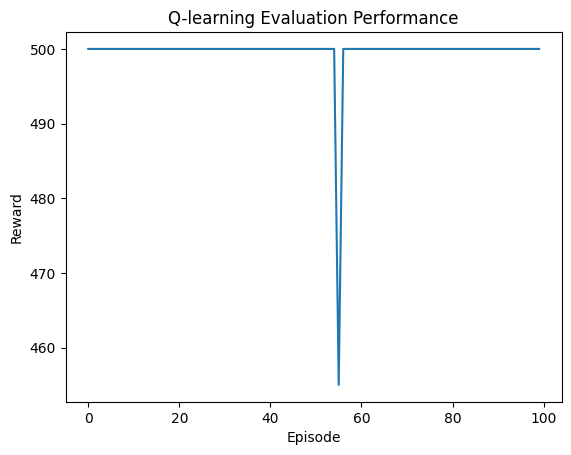

Average Cumulative Reward: 499.55
Reward Standard Deviation: 4.48
Is my agent good enough? True


In [41]:
# Evaluate the trained agent
mean_reward, std_reward = evaluate(agent, env, num_episodes=100)

# Show results
print(f"Average Cumulative Reward: {mean_reward:.2f}")
print(f"Reward Standard Deviation: {std_reward:.2f}")
print("Is my agent good enough?", mean_reward > 195)

In [45]:
def get_video_path(video_name: str = "default", video_folder: str = "video") -> str:
    os.makedirs(video_folder, exist_ok=True)
    if video_name == "default":
        video_name = f"QL_agent_{datetime.datetime.now().strftime('%Y%m%d%H%M%S')}"
    if not video_name.endswith(".mp4"):
        video_name += ".mp4"
    return os.path.join(video_folder, video_name)

def render_episode(agent, env, video_name="default", fps=20, width=600, height=400, video_folder="video"):
    """Render one episode of the agent's performance and save as video."""
    render_env = gym.make('CartPole-v1', render_mode='rgb_array')
    
    frames = []
    observation, _ = render_env.reset()
    
    while True:
        state = get_hashed_state(observation)
        action = np.argmax(agent.q_table[state]) 
        
        frame = render_env.render()
        if frame is not None:
            frames.append(Image.fromarray(frame).resize((width, height)))
        
        observation, reward, terminated, truncated, _ = render_env.step(action)
        
        if terminated or truncated:
            break
    
    render_env.close()
    
    if frames: 
        video_path = get_video_path(video_name=video_name, video_folder=video_folder)
        imageio.mimsave(video_path, frames, fps=fps)
        return Video(video_path)
    else:
        print("Warning: No frames were captured during rendering.")
        return None

# Render and save the episode
%pip install pygame
import pygame
from pygame import gfxdraw
render_episode(agent, env)

   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
   ------------ --------------------------- 3.4/10.6 MB 20.2 MB/s eta 0:00:01
   -------------------- ------------------- 5.5/10.6 MB 14.0 MB/s eta 0:00:01
   ---------------------------- ----------- 7.6/10.6 MB 12.4 MB/s eta 0:00:01
   ----------------------------------- ---- 9.4/10.6 MB 11.7 MB/s eta 0:00:01
   ---------------------------------------- 10.6/10.6 MB 10.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
